# Home Price Prediction: DATA 273P Final Project
### Data sourced from: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
### Grace Newman, Kaitlyn Morenzone, Abigail Mori

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Data Ingestion and Preprocessing
The 'test.csv' file has no predictor column, as Kaggle intends users to submit the predictions of their regression model on that test dataset blindly. Therefore, we will split the training dataset in order to measure accuracy within this notebook.

In [4]:
## ingest data
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')

In [5]:
train_df.set_index('Id', inplace=True)

In [6]:
print(train_df.shape)

(1460, 80)


There is high dimensionality in this dataset, so we will drop some columns that we find least likely to be good predictors of home price.

In [8]:
# drop some non-predictive columns
drop_cols = ['Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope']
train_df = train_df.drop(columns=drop_cols)

Cateogorical columns are stored as 'Object' types. We need to encode these values to integers so that they can be used in regression.

In [10]:
# listing categorical columns
categorical = []

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        categorical.append(col)

# using pd.get_dummies to encode 
train_data = pd.get_dummies(train_df, columns=categorical, drop_first=True)

We will drop columns that have null values present. In this case, our data has no null values!

In [12]:
# check null proportion of each column
null_percentages = train_data.isnull().sum() / len(train_data) * 100
drops = null_percentages[null_percentages > 0]
drop_cols = drops.index

# drop columns with nulls
train_data = train_data.drop(columns=drop_cols)

Here, we will split the training data into training and testing sets.

In [14]:
# splitting data into 80-20 train-test split
train, test = train_test_split(train_data, test_size=0.2)

X_train = train.loc[:, train.columns != 'SalePrice']
y_train = train['SalePrice']

X_test = test.loc[:, test.columns != 'SalePrice']
y_test = test['SalePrice']

Let's look at the distribution of our target variable, Sale Price, to determine which models we might try first.

/Users/gracenewman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

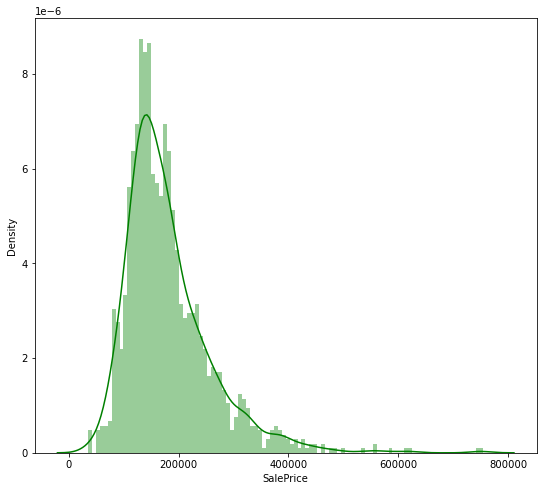

In [16]:
plt.figure(figsize=(9, 8))
sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

Given the nonlinear distribution of the target variable, Sale Price, we might try a non-parametric model first.

## Random Forest Model

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

def get_best_params(X, y):
    random_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

    rf_model = RandomForestRegressor()
    rf_cv = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, scoring='neg_root_mean_squared_error')
    rf_cv.fit(X, y)
    print(rf_cv.best_params_)
    return rf_cv.best_params_

In [20]:
# getting best fit parameters
best_params = get_best_params(X_train, y_train)

# initializing model and setting parameters to best found
rf_model = RandomForestRegressor(criterion = 'squared_error', bootstrap=True, oob_score=True)
rf_model = rf_model.set_params(**best_params)

# fitting model
rf_model.fit(X_train, y_train)

# getting OOB accuracy score
oob_score = rf_model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# getting cross-validated accuracy score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Mean CV accuracy: %0.2f, SD: %0.2f" % (cv_scores.mean(), cv_scores.std()))

{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
Out-of-Bag Score: 0.8634855337903755
Mean CV accuracy: 0.86, SD: 0.06


Due to the high dimensionality of the dataset, let's try a reduced model. We'll do this by dropping the features with the lowest importance in the model. We will drop features with an importance < 0.005, which is approximately the median importance level.

Features in full model: 232
Features in reduced model: 14


<AxesSubplot:>

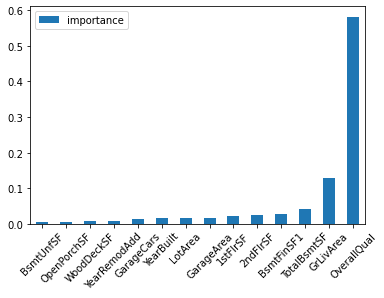

In [22]:
# getting feature importances
feats = {}
for feature, importance in zip(X_train.columns, rf_model.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
print(f"Features in full model: {len(importances)}")

# filtering features with importance = 0
importances = importances[importances['importance'] >= 0.005]
print(f"Features in reduced model: {len(importances)}")

keep_features = importances.index.to_list()

# reducing training data
X_train_reduced = X_train[keep_features]
X_test_reduced = X_test[keep_features]

# plotting feature importances
importances.sort_values(by='importance').plot(kind='bar', rot=45)

Let's train the reduced model using the same method as we did with the full model.

In [24]:
# getting best fit parameters
best_params = get_best_params(X_train, y_train)

# initializing reduced model and setting parameters to best found
rf_model_reduced = RandomForestRegressor(criterion = 'squared_error', bootstrap=True, oob_score=True)
rf_model_reduced = rf_model_reduced.set_params(**best_params)

# fitting reduced model
rf_model_reduced.fit(X_train, y_train)

# getting OOB accuracy score
oob_score = rf_model_reduced.oob_score_
print(f'Reduced Out-of-Bag Score: {oob_score}')

# getting cross-validated accuracy score
cv_scores = cross_val_score(rf_model_reduced, X_train_reduced, y_train, cv=5)
print("Reduced Mean CV accuracy: %0.2f, SD: %0.2f" % (cv_scores.mean(), cv_scores.std()))

{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
Reduced Out-of-Bag Score: 0.8653353482476351
Reduced Mean CV accuracy: 0.86, SD: 0.06


On average, we get a marginal increase in accuracy on the training set. Let's evaluate the test set.

In [26]:
rf_model.fit(X_test, y_test)
rf_model_reduced.fit(X_test_reduced, y_test)

# full model scoring
oob_score = rf_model.oob_score_
print(f'Full Out-of-Bag Score: {oob_score}')

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Full Mean CV accuracy: %0.2f, SD: %0.2f" % (cv_scores.mean(), cv_scores.std()))

# reduced model scoring
oob_score = rf_model_reduced.oob_score_
print(f'Reduced Out-of-Bag Score: {oob_score}')

cv_scores = cross_val_score(rf_model_reduced, X_train_reduced, y_train, cv=5)
print("Reduced Mean CV accuracy: %0.2f, SD: %0.2f" % (cv_scores.mean(), cv_scores.std()))

Full Out-of-Bag Score: 0.7681861601261954
Full Mean CV accuracy: 0.86, SD: 0.06
Reduced Out-of-Bag Score: 0.754800786881857
Reduced Mean CV accuracy: 0.86, SD: 0.06


We do see a marginal increase in the accuracy of the reduced model. Due to its significanty lower dimensionality, the reduced model is preferred over the full.

## XGBoost Model
XGBoost is a popular gradient-boosted decision tree algorithm that has been used for the task of home price prediction in numerous papers. Let's apply it here!

In [29]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

In [30]:
# re-loading train/test data
# splitting data into 80-20 train-test split
train, test = train_test_split(train_data, test_size=0.2)

X_train = train.loc[:, train.columns != 'SalePrice']
y_train = train['SalePrice']

X_test = test.loc[:, test.columns != 'SalePrice']
y_test = test['SalePrice']

In [31]:
# Fit the estimator on the train set and score it on both sets
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score

clf = xgb.XGBRegressor(objective='reg:squarederror')

results = {}
# training
est, train_score, test_score = fit_and_score(
    clf, X_train, X_test, y_train, y_test
)
results[est] = (train_score, test_score)

[0]	validation_0-rmse:66249.46920
[1]	validation_0-rmse:54162.01454
[2]	validation_0-rmse:44267.61786
[3]	validation_0-rmse:37618.96588
[4]	validation_0-rmse:33044.13838
[5]	validation_0-rmse:31605.25128
[6]	validation_0-rmse:30107.57559
[7]	validation_0-rmse:29518.45224
[8]	validation_0-rmse:28884.96460
[9]	validation_0-rmse:28624.31506
[10]	validation_0-rmse:28339.31426
[11]	validation_0-rmse:28191.29873
[12]	validation_0-rmse:28247.28526
[13]	validation_0-rmse:28124.59291
[14]	validation_0-rmse:28098.08060
[15]	validation_0-rmse:28108.86961
[16]	validation_0-rmse:27989.75121
[17]	validation_0-rmse:28020.72841
[18]	validation_0-rmse:27958.69515
[19]	validation_0-rmse:27944.96292
[20]	validation_0-rmse:28034.28108
[21]	validation_0-rmse:28018.67154
[22]	validation_0-rmse:28076.03498
[23]	validation_0-rmse:28079.36133
[24]	validation_0-rmse:27960.61744
[25]	validation_0-rmse:27954.92337
[26]	validation_0-rmse:27894.79557
[27]	validation_0-rmse:27907.76242
[28]	validation_0-rmse:27844.1

The full XGBoost model performs similarly to the random forest models, but is more prone to overfitting. Let's try a reduced XGBoost model to compare, using the same parameter reduction method as we did earlier. Then, we'll adjust the hyperparameters of the model to avoid overfitting.

Features in full model: 232
Features in reduced model: 12


<AxesSubplot:>

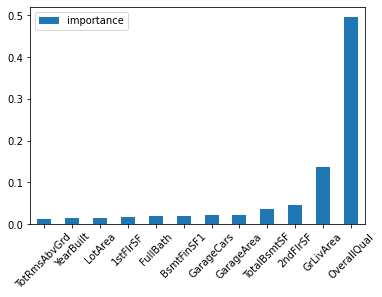

In [33]:
# getting feature importances
feats = {}
for feature, importance in zip(X_train.columns, rf_model.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
print(f"Features in full model: {len(importances)}")

# filtering features with importance = 0
importances = importances[importances['importance'] >= 0.01]
print(f"Features in reduced model: {len(importances)}")

keep_features = importances.index.to_list()

# reducing training data
X_train_reduced = X_train[keep_features]
X_test_reduced = X_test[keep_features]

# plotting feature importances
importances.sort_values(by='importance').plot(kind='bar', rot=45)

In [34]:
clf_reduced = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, min_child_weight=2, gamma=2)

results = {}

est, train_score_reduced, test_score_reduced = fit_and_score(
    clf_reduced, X_train_reduced, X_test_reduced, y_train, y_test
)
results[est] = (train_score_reduced, test_score_reduced)

[0]	validation_0-rmse:68191.06123
[1]	validation_0-rmse:57400.41955
[2]	validation_0-rmse:50566.88696
[3]	validation_0-rmse:43950.13436
[4]	validation_0-rmse:39193.34329
[5]	validation_0-rmse:38682.74168
[6]	validation_0-rmse:36760.84022
[7]	validation_0-rmse:35774.68532
[8]	validation_0-rmse:34271.05815
[9]	validation_0-rmse:33112.19029
[10]	validation_0-rmse:33229.29883
[11]	validation_0-rmse:32585.23246
[12]	validation_0-rmse:31627.39357
[13]	validation_0-rmse:31919.55057
[14]	validation_0-rmse:31722.75344
[15]	validation_0-rmse:31612.89829
[16]	validation_0-rmse:31364.20426
[17]	validation_0-rmse:31501.73043
[18]	validation_0-rmse:31246.01760
[19]	validation_0-rmse:31187.78159
[20]	validation_0-rmse:31182.85728
[21]	validation_0-rmse:31150.76709
[22]	validation_0-rmse:31410.94555
[23]	validation_0-rmse:31412.36123
[24]	validation_0-rmse:31191.00440
[25]	validation_0-rmse:31163.10034
[26]	validation_0-rmse:31227.89934
[27]	validation_0-rmse:31198.79077
[28]	validation_0-rmse:31219.6

In [35]:
# full model evaluation
print(f"Full XGBoost train score: {train_score}")
print(f"Full XGBoost test score: {test_score}")

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Full XGBoost Mean CV accuracy: %0.2f, SD: %0.2f\n" % (cv_scores.mean(), cv_scores.std()))

# reduced model evaluation
print(f"Reduced XGBoost train score: {train_score_reduced}")
print(f"Reduced XGBoost test score: {test_score_reduced}")

cv_scores_reduced = cross_val_score(clf_reduced, X_train_reduced, y_train, cv=5)
print("Reduced XGBoost Mean CV accuracy: %0.2f, SD: %0.2f" % (cv_scores_reduced.mean(), cv_scores_reduced.std()))

Full XGBoost train score: 0.9997151514450491
Full XGBoost test score: 0.8903140873382431
Full XGBoost Mean CV accuracy: 0.86, SD: 0.05

Reduced XGBoost train score: 0.9726994549114042
Reduced XGBoost test score: 0.8595933900511185
Reduced XGBoost Mean CV accuracy: 0.82, SD: 0.05


We achieve similar mean accuracy and variance with the reduced model. Unfortunately, the overfitting problem still stands. Perhaps further hyperparameter tuning could address this issue.

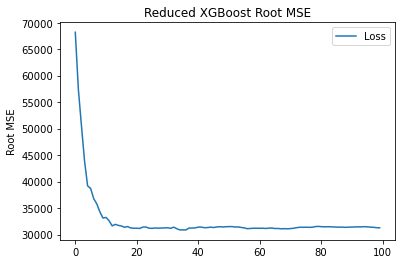

In [37]:
results = clf_reduced.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Loss')
ax.legend()
plt.ylabel('Root MSE')
plt.title('Reduced XGBoost Root MSE')
plt.show()

The loss function appears smooth throughout epochs, which indicates a stable training process.

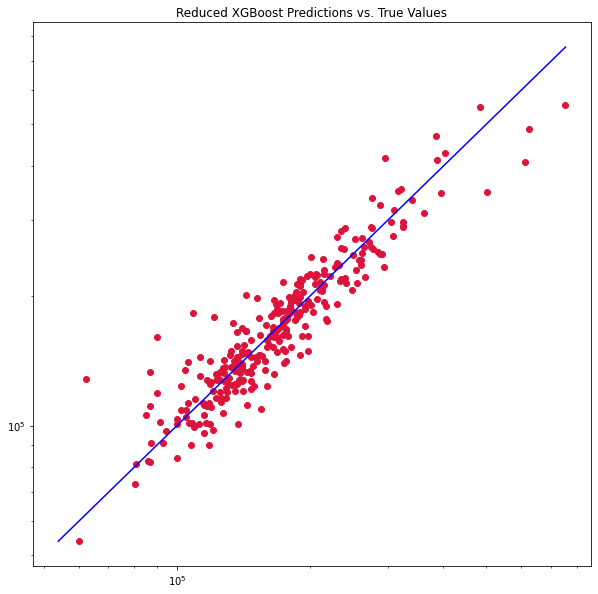

In [39]:
y_pred = clf_reduced.predict(X_test_reduced)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Reduced XGBoost Predictions vs. True Values')
plt.show()

With the exception of a few outliers, the reduced XGBoost model achieves fairly good accuracy on the test set.

## Conclusions
While it may be exciting to implement a newer model like XGBoost, in this situation, the reduced Random Forest model slightly outperforms the other algorithm. With the evaluations of each model are extremely similar, it is favorable to opt for a simpler model with a lower dimensional parameter space. In our opinion, the reduced Random Forest model is the best choice for housing price prediction!